# Sujet 4 : Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques

Un modèle simple et fréquemment utilisé pour décrire la performance d'une connexion de réseau consiste à supposer que le temps d'envoi T pour un message dépend principalement de sa taille S (nombre d'octets) et de deux grandeurs propres à la connexion : la latence L (en secondes) et la capacité C (en octets/seconde). La relation entre ces quatre quantités est T(S) = L + S/C. Ce modèle néglige un grand nombre de détails. D'une part, L et C dépendent bien sûr du protocole de communication choisi mais aussi dans une certaine mesure de S. D'autre part, la mesure de T(S) comporte en général une forte composante aléatoire. Nous nous intéressons ici au temps moyen qu'il faut pour envoyer un message d'une taille donnée.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import os
import shutil
import gzip
import re
import numpy as np

On définit nos sources de données et on les récupére en local si on ne les a pas encore

In [2]:
data_set_1_url = "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz"
data_set_2_url = "http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/stackoverflow.log.gz"

data_set_1 = "liglab2.log"
data_set_2 = "stackoverflow.log"

# Fichier de data 1
if not(os.path.isfile(data_set_1)):
    r = requests.get(data_set_1_url, allow_redirects=True)
    open('liglab2.log.gz', 'wb').write(r.content)
    with gzip.open('liglab2.log.gz', 'rb') as f_in:
        with open(data_set_1, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Fichier de data 2
if not(os.path.isfile(data_set_2)):
    r = requests.get(data_set_2_url, allow_redirects=True)
    open('stackoverflow.log.gz', 'wb').write(r.content)
    with gzip.open('stackoverflow.log.gz', 'rb') as f_in:
        with open(data_set_2, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

On utilise du regex pour vérifier que les logs sont conformes au format attendus et pour les convertir en données utilisables, que l'on stocke dans un dictionnaire.
Les lignes rencontrées qui n'ont pas le format attendues sont affichées par le programme dans la sortie standard.

## Analyse du jeu de données 1

In [3]:
def extract_datas_from_logs(fileName):
    processLine = re.compile(r"\[(\d+.\d+)\] (\d+) bytes from .*: icmp_seq=\d+ ttl=\d+ time=([\d\.]+) ms")

    resDict = {'timestamps': [], 'size': [], 'RTT': []}
    
    malformed = 0
    
    with open(fileName, 'r') as f:
        for l in f:
            r = processLine.search(l)
            # Verify that all line contains a sample
            if r is None:
                malformed += 1
            else:
                g = r.groups()
                resDict['timestamps'].append(float(g[0]))
                resDict['size'].append(int(g[1]))
                resDict['RTT'].append(float(g[2]))
    print('Il y a %d lignes malformées dans le fichier' % malformed)
    return resDict

resDict = extract_datas_from_logs(data_set_1)

Il y a 377 lignes malformées dans le fichier


On affiche les dix premières entrées du dictionnaire pour vérifier que les données sont cohérentes

In [4]:
resDict['timestamps'][:10]

[1421761682.052172,
 1421761682.277315,
 1421761682.502054,
 1421761682.729257,
 1421761682.934648,
 1421761683.160397,
 1421761683.443055,
 1421761683.672157,
 1421761683.899933,
 1421761684.122687]

In [5]:
resDict['size'][:10]

[665, 1373, 262, 1107, 1128, 489, 1759, 1146, 884, 1422]

In [6]:
resDict['RTT'][:10]

[22.5, 21.2, 21.2, 23.3, 1.41, 21.9, 78.7, 25.1, 24.0, 19.5]

On représente graphiquement l'évolution du temps de transmission au cours du temps à différentes échelles de temps

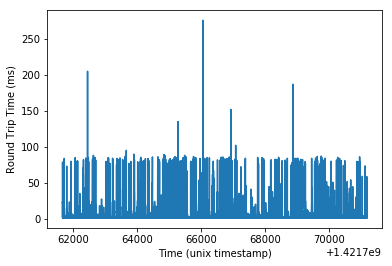

In [7]:
# On affiche toutes les mesures
plt.xlabel("Time (unix timestamp)")
plt.ylabel("Round Trip Time (ms)")
plt.plot(resDict['timestamps'], resDict['RTT'])

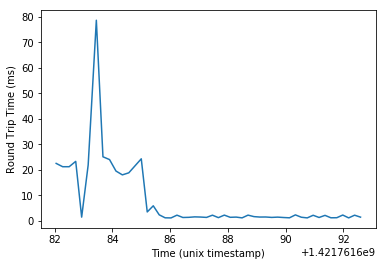

In [8]:
# On affiche seulement les 10 premières mesures
plt.xlabel("Time (unix timestamp)")
plt.ylabel("Round Trip Time (ms)")
plt.plot(resDict['timestamps'][:50], resDict['RTT'][:50])

Pour avoir une intuition sur l'impact de la taille dans le RTT, on affiche la courbe des tailles correspondantes aux temps ci-dessus.

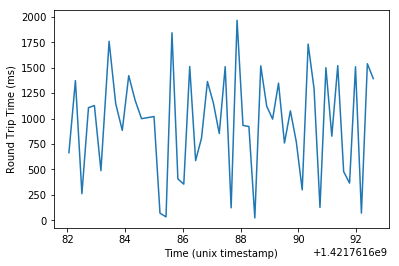

In [9]:
# On affiche seulement les 10 premières mesures
plt.xlabel("Time (unix timestamp)")
plt.ylabel("Round Trip Time (ms)")
plt.plot(resDict['timestamps'][:50], resDict['size'][:50])

On remarque que les deux courbes ont des têtes bien différentes et on n'bserve pas visuellement de correlation. Il semble donc complexe d'expliquer les variations de RTT seulement avec la taille des messages.

Pour pousser l'analyze, on représente le temps de transmission en fonction de la taille des messages.

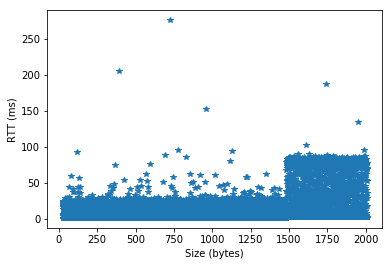

In [10]:
plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict['size'], resDict['RTT'], ls="", marker="*")

On remarque visuellement que le comportement de la variabilité change au delà de ~1500 bytes. Une possibilité est que pour les requêtes de taille supérieurs, le paquet subisse une [fragmentation IP](https://en.wikipedia.org/wiki/IP_fragmentation), le [MTU](https://fr.wikipedia.org/wiki/Maximum_transmission_unit) sur les réseaux ethernets étant classiquement fixé à 1500 bytes et les paquets correspondants devant donc êtres fragmentés avant envoi et réassemblés après réception. Si le MTU est effectivement le soucis, nous devons théoriquement splitter à 1492 (1500 - la taille du header ICMP).

Forts de cette information, on split notre jeu de données en deux parties: les données avec une taille de moins de 1492 et et celles avec une taille supérieure à 1492.

In [11]:
def split_datas_at_value(data, value):
    resDict_sub = {
        'timestamps': [],
        'size': [],
        'RTT': []
    }
    resDict_over = {
        'timestamps': [],
        'size': [],
        'RTT': []
    }
    for i in range(len(data['size'])):
        if data['size'][i] <= value:
            resDict_sub['size'].append(data['size'][i])
            resDict_sub['timestamps'].append(data['timestamps'][i])
            resDict_sub['RTT'].append(data['RTT'][i])
        else:
            resDict_over['size'].append(data['size'][i])
            resDict_over['timestamps'].append(data['timestamps'][i])
            resDict_over['RTT'].append(data['RTT'][i])
    return resDict_sub, resDict_over

resDict_sub_1500, resDict_over_1500 = split_datas_at_value(resDict, 1492)

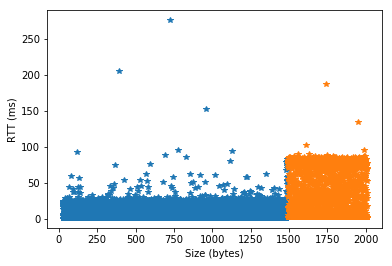

In [12]:
plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict_sub_1500['size'], resDict_sub_1500['RTT'], ls="", marker="*")
plt.plot(resDict_over_1500['size'], resDict_over_1500['RTT'], ls="", marker="*")

Visuellement, le split paraît correct.
On s'intéresse donc maintenant à la dépendance du RTT par rapport à la taille sur les deux sections des données.

On réalise une régression linéaire sur les deux parties.

In [13]:
reg1 = np.polyfit(resDict_sub_1500['size'], resDict_sub_1500['RTT'], 1)
reg2 = np.polyfit(resDict_over_1500['size'], resDict_over_1500['RTT'], 1)

Numpy nous renvoit les coefficient de la régression linéaire sous forme d'un tableau [a, b]. On peut ensuite le transformer pour retrouver les paramétres L et C du modéle T(S) = L + S/C. La transformation est : L = b et C = 1/a.

In [14]:
print(reg1)
print(reg2)

[4.75022492e-04 3.20041914e+00]
[2.46441831e-03 5.49930604e+00]


Sur la première partie des données, on trouve $L \approx 3.2$ et $C \approx 2105$.

Sur la seconde partie des données, on trouve $L \approx 5.5$ et $C \approx 407$.

On peut maintenant afficher la régression avec les valeurs mesurées.

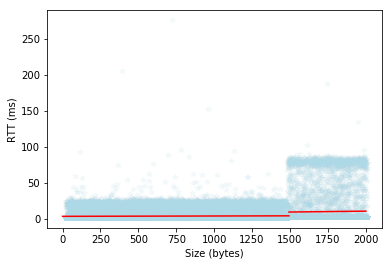

In [15]:
x1 = np.linspace(0,1493, 1492)
x2 = np.linspace(1493, 2000, 506)

y1 = reg1[0]*x1 + reg1[1]*np.ones(x1.shape)
y2 = reg2[0]*x2 + reg2[1]*np.ones(x2.shape)

plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict_sub_1500['size'], resDict_sub_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(resDict_over_1500['size'], resDict_over_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(x1, y1, color='red')
plt.plot(x2, y2, color='red')

On peut également s'intéresser à la régression des temps minimaux pour chaque taille. Pour cela, on sélectionne le temps minimum pour chaque taille de paquet et on répéte les régressions ci-dessus.

In [16]:
# On créé les abscisses et le tableau des minimums
def create_min_array_with_split(resDict, split_value):
    
    x = [i for i in range(0,max(resDict['size']) + 1)]
    min_tab = [np.inf]*len(x)

    for i in range(len(resDict['size'])):
        if min_tab[resDict['size'][i]] > resDict['RTT'][i]:
            min_tab[resDict['size'][i]] = resDict['RTT'][i]

    # On retire les données erronnées
    filtered_x_sub_1500 = []
    filtered_min_tab_sub_1500 = []
    filtered_x_over_1500 = []
    filtered_min_tab_over_1500 = []

    for i in range(len(x)):
        if min_tab[i] != np.inf:
            if x[i] <= split_value:
                filtered_x_sub_1500.append(x[i])
                filtered_min_tab_sub_1500.append(min_tab[i])
            else:
                filtered_x_over_1500.append(x[i])
                filtered_min_tab_over_1500.append(min_tab[i])
    return filtered_x_sub_1500, filtered_min_tab_sub_1500, filtered_x_over_1500, filtered_min_tab_over_1500

x_sub_1500, min_tab_sub_1500, x_over_1500, min_tab_over_1500 = create_min_array_with_split(resDict, 1492)

# On fait les régressions
reg1_min = np.polyfit(x_sub_1500, min_tab_sub_1500, 1)
reg2_min = np.polyfit(x_over_1500, min_tab_over_1500, 1)
print(reg1_min)
print(reg2_min)

[2.60965854e-04 1.02118720e+00]
[2.43235028e-04 1.74080472e+00]


Sur la première partie des données, on trouve $L \approx 1.02$ et $C \approx 3846$.

Sur la seconde partie des données, on trouve $L \approx 1.74$ et $C \approx 4115$.

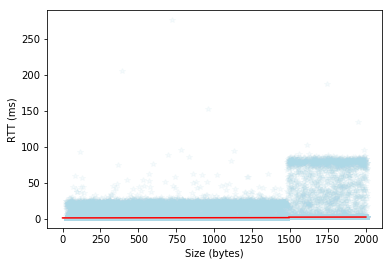

In [17]:
x1 = np.linspace(0,1493, 1492)
x2 = np.linspace(1493, 2000, 506)

y1 = reg1_min[0]*x1 + reg1_min[1]*np.ones(x1.shape)
y2 = reg2_min[0]*x2 + reg2_min[1]*np.ones(x2.shape)

plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict_sub_1500['size'], resDict_sub_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(resDict_over_1500['size'], resDict_over_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(x1, y1, color='red')
plt.plot(x2, y2, color='red')

## Analyse du jeu de données 2

Pour analyser le second jeu de données, on applique le même process que pour le premier. On commence par récupérer les logs et les transformer en données utilisables.

In [18]:
resDict = extract_datas_from_logs(data_set_2)

Il y a 63 lignes malformées dans le fichier


In [19]:
resDict['timestamps'][:10]

[1421771203.082701,
 1421771203.408254,
 1421771203.73973,
 1421771204.05663,
 1421771204.372224,
 1421771204.688367,
 1421771205.005514,
 1421771205.321112,
 1421771205.637464,
 1421771205.953472]

In [20]:
resDict['size'][:10]

[1257, 454, 775, 1334, 83, 694, 1577, 632, 405, 1419]

In [21]:
resDict['RTT'][:10]

[120.0, 120.0, 126.0, 112.0, 111.0, 111.0, 112.0, 111.0, 111.0, 111.0]

Ensuite on affiche les données et on cherche une intuition visuelle.

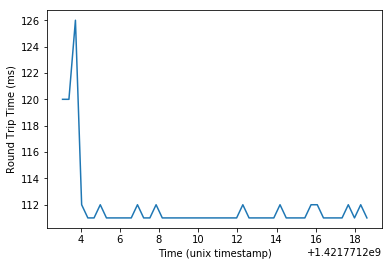

In [22]:
# On affiche seulement les 10 premières mesures
plt.xlabel("Time (unix timestamp)")
plt.ylabel("Round Trip Time (ms)")
plt.plot(resDict['timestamps'][:50], resDict['RTT'][:50])

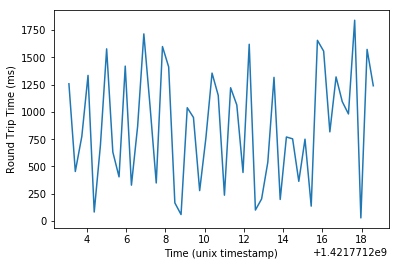

In [23]:
# On affiche seulement les 10 premières mesures
plt.xlabel("Time (unix timestamp)")
plt.ylabel("Round Trip Time (ms)")
plt.plot(resDict['timestamps'][:50], resDict['size'][:50])

Comme sur le jeu de données 1, il semble qu'il faille pousser un peu plus l'analyse.

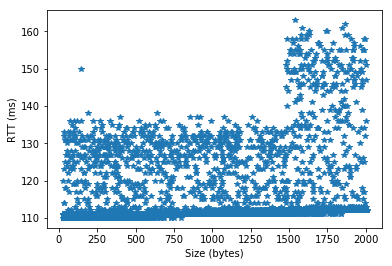

In [24]:
plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict['size'], resDict['RTT'], ls="", marker="*")

On retrouve la même fracture à ~1500 bytes que sur le premier jeu de données. Mais on remarque assez facilement qu'elle n'a pas l'air de concerner la valeur minimale.

In [25]:
resDict_sub_1500, resDict_over_1500 = split_datas_at_value(resDict, 1492)

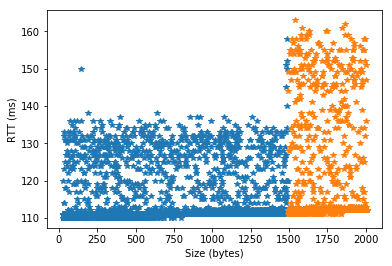

In [26]:
plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict_sub_1500['size'], resDict_sub_1500['RTT'], ls="", marker="*")
plt.plot(resDict_over_1500['size'], resDict_over_1500['RTT'], ls="", marker="*")

On réapplique la régression linéaire avant de l'afficher avec les données.

In [27]:
reg1 = np.polyfit(resDict_sub_1500['size'], resDict_sub_1500['RTT'], 1)
reg2 = np.polyfit(resDict_over_1500['size'], resDict_over_1500['RTT'], 1)
print(reg1)
print(reg2)

[2.29726279e-04 1.13135332e+02]
[-1.4810656e-03  1.1946463e+02]


Sur la première partie des données, on trouve $L \approx 113$ et $C \approx 4347$.

Sur la seconde partie des données, on trouve un a négatif, ce qui est très incohérent avec le modèle, $C = 1/a$ étant censé être le débit de la connection et donc une grandeur positive.

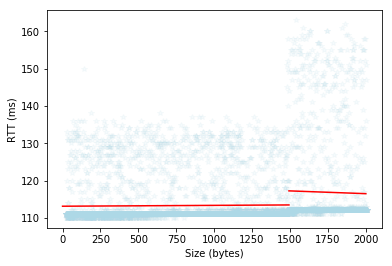

In [28]:
x1 = np.linspace(0,1493, 1492)
x2 = np.linspace(1493, 2000, 506)

y1 = reg1[0]*x1 + reg1[1]*np.ones(x1.shape)
y2 = reg2[0]*x2 + reg2[1]*np.ones(x2.shape)

plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict_sub_1500['size'], resDict_sub_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(resDict_over_1500['size'], resDict_over_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(x1, y1, color='red')
plt.plot(x2, y2, color='red')

Cela remet fortement en question la pertinence d'applique la régression sur toutes les valeurs et pas seulement sur les minimums. On applique donc la régression sur les minimums

In [29]:
x_sub_1500, min_tab_sub_1500, x_over_1500, min_tab_over_1500 = create_min_array_with_split(resDict, 1492)

# On fait les régressions
reg1_min = np.polyfit(x_sub_1500, min_tab_sub_1500, 1)
reg2_min = np.polyfit(x_over_1500, min_tab_over_1500, 1)
print(reg1_min)
print(reg2_min)

[3.57496224e-04 1.10878770e+02]
[4.99749629e-04 1.11655553e+02]


Sur la première partie des données, on trouve $L \approx 111$ et $C \approx 2801$.

Sur la première partie des données, on trouve $L \approx 111$ et $C \approx 2000$.

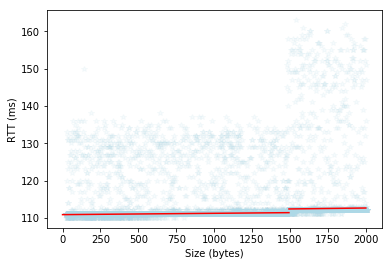

In [30]:
x1 = np.linspace(0,1493, 1492)
x2 = np.linspace(1493, 2000, 506)

y1 = reg1_min[0]*x1 + reg1_min[1]*np.ones(x1.shape)
y2 = reg2_min[0]*x2 + reg2_min[1]*np.ones(x2.shape)

plt.xlabel('Size (bytes)')
plt.ylabel('RTT (ms)')
plt.plot(resDict_sub_1500['size'], resDict_sub_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(resDict_over_1500['size'], resDict_over_1500['RTT'], ls="", marker="*", alpha=0.1, color='lightblue')
plt.plot(x1, y1, color='red')
plt.plot(x2, y2, color='red')

## Conclusion
Il semblerait que la relation entre RTT et taille soit assez complexe et qu'il y ait un grand écart type dans les mesures de RTT pour une même taille de paquet. Toutefois, le minimum de RTT pour une taille donnée semble être corrélé à la taille du paquet et la modélisation simple qu'on utilise (T(S) = L + S/C) semble assez cohérente dans ce cas.

On note toutefois que les valeurs qu'on a trouvé pour C, de l'ordre du Ko/s semblent assez faibles et qu'on gagnerait à faire des mesures avec des tailles beaucoup plus grandes de paquets pour avoir une plage plus grande sur laquelle effectuer la régression.

On note également que la méthode np.polyfit() ne renvoit pas la R² ni l'incertitude sur la régression et on est réduit à se baser sur la cohérence visuelle des données. Le travail réalisé ici ne permet que d'avoir une intuition sur l'évolution du RTT avec la taille des paquets sur une connection réseau.